In [9]:
#image analysis
import sys
import os
sys.path.append(os.path.abspath('../../'))

from matplotlib import cm

try:
    os.mkdir("logs")
except:
    pass


import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from alienlab.regression_func import *
import copy
from VoltageIntensityClass import VoltageIntensity
from tqdm import tqdm

from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from skimage.transform import resize

import mvgavg

import scipy

import tifffile as tiff

#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity


from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from csbdeep.utils import Path, normalize
model = StarDist2D.from_pretrained('2D_demo')


import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets
from alienlab.regression_func import platt, residuals
from alienlab.utils import clip
from alienlab.segment import uniform_mask, label_to_data
from alienlab.widget import click_to_graph
#%matplotlib inline


from mvgavg import mvgavg


def get_fit(decay, time, give_y = False): 
    
    time = time - time[0]

    time_spread = time.max()-time.min()
    start = np.mean(decay[0])
    stop = np.mean(decay[-5:])
    #if len(decay)<15:
    #    x0 = [start, time_spread/10, stop]
    #else:
    x0 = [start, time_spread, stop]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                args = (time, decay, exp_decay))
    
    if give_y:
        return np.array(parameters_estimated.x), exp_decay(parameters_estimated.x, time)
    else:
        return np.array(parameters_estimated.x)
    
def make_fit(decay, time_array):
    plt.figure()
    params, ypred = get_fit(decay, time_array, give_y = True)
    plt.plot(time_array, ypred, label = params[1])
    plt.plot(time_array, decay, '.')
    plt.xlabel("time(s)")
    plt.ylabel("fluorescence")
    plt.legend()
    
p = alienlab.plot.PlotFigure()


Found model '2D_demo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


In [10]:
#file_path = "ENTER NAME OF THE FILE YOU DROPPED IN THE FILE SECTION HERE" 
file_folder = "."#askdirectory(title = 'Select an experiment folder', initialdir="G:/DREAM/from_github/PAMFluo/Experiments")  # pops up a window to select your file 
# uncomment this line if you use this jupyter notebook locally
#'G:/DREAM/from_github/PAMFluo/Experiments/2021-06-24_12_12_Ek_video'
file_folder

'.'

In [20]:


# Initialize plotting tools
g = alienlab.plot.ShowFigure()
g.figsize = (15,7)
g.save_folder = "images"
g.date = False
p = alienlab.plot.PlotFigure()
p.figsize = (15,7)
p.save_folder = "images"
p.date = False

def predict_labels(image):
    axis_norm = (0,1)   # normalize channels independently
    lbl_cmap = random_label_cmap()
    img = normalize(image, 1,99.9, axis=axis_norm)
    labels, details = model.predict_instances(img)
    return labels

def label_to_data(mask, FO):
    # Item time trajectories with overlaps
    # create a dictionnary with one entry for each item:
    '''
    { '1.0': {'x_coords': np array, x coordinates in HQ}
                'y_coords': np array,  y coordinates in HQ
                'binned_coords': set, couples of (x,y) coordinates in binned video
                'surface': number of pixels in the item in HQ
                'pixel_values': array, size: (N, s) where N is number of frames and s surface
                'mean': array, size N, mean value of the item intensity for each frame
                'std':  array, size N, std value of the item intensity for each frame
                'remains' : True, the item is present in this segmentation step
                }
    '2.0': {'x_coords'...
                    }
        }
    '''
    segmented = mask
    items = np.unique(segmented) #returns the set of values in items, corresponds to the values of the markers of local_maxima

    items_dict = {}
    for k in tqdm(items):
        x_coords, y_coords = np.nonzero(segmented == k)
        pixel_values = FO.frames[:,x_coords, y_coords]

        key = str(k)
        items_dict[key] = {}
        items_dict[key]['x_coords'] = x_coords
        items_dict[key]['y_coords'] = y_coords
        items_dict[key]['pixel_values'] = pixel_values
        items_dict[key]['surface'] = pixel_values.shape[1]
        items_dict[key]['mean'] = np.mean(pixel_values, axis = 1)
        items_dict[key]['std'] = np.std(pixel_values, axis = 1)
        items_dict[key]['remains'] = True

    return items_dict
    


In [21]:
def init_image(file_path):
    frames_full = skimage.io.imread(file_path)

    #frames_full = np.stack([frames_full[:,:,1]]*10, 0) 
    #uncomment this line if you have a single RGB image. The [:,:,1] stands for selection of the green channel

    FO = FramesOperator(frames_full)
    im = normalize(FO.frames[0], 0, 1)
    im = grey_to_rgb(im)*255
    #FO.compute_stats()

    # CROP
    #y, x = alienlab.io.select_roi(np.uint8(im)) #select area of interest

    FO.x = 100, 800
    FO.y = 100, 800
    #FO.crop() #crop image
    return FO

yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.34it/s]


yo2
yo3
14
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.47it/s]


yo2
yo3
14
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.47it/s]


yo2
yo3
14
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.47it/s]


yo2
yo3
14
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.13it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.16it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.12it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.13it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.12it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.14it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.13it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.10it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.12it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.10it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.12it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.13it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.14it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.13it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.14it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.17it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.13it/s]


yo2
yo3
12
yo0
yo1


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.14it/s]


yo2
yo3
12


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
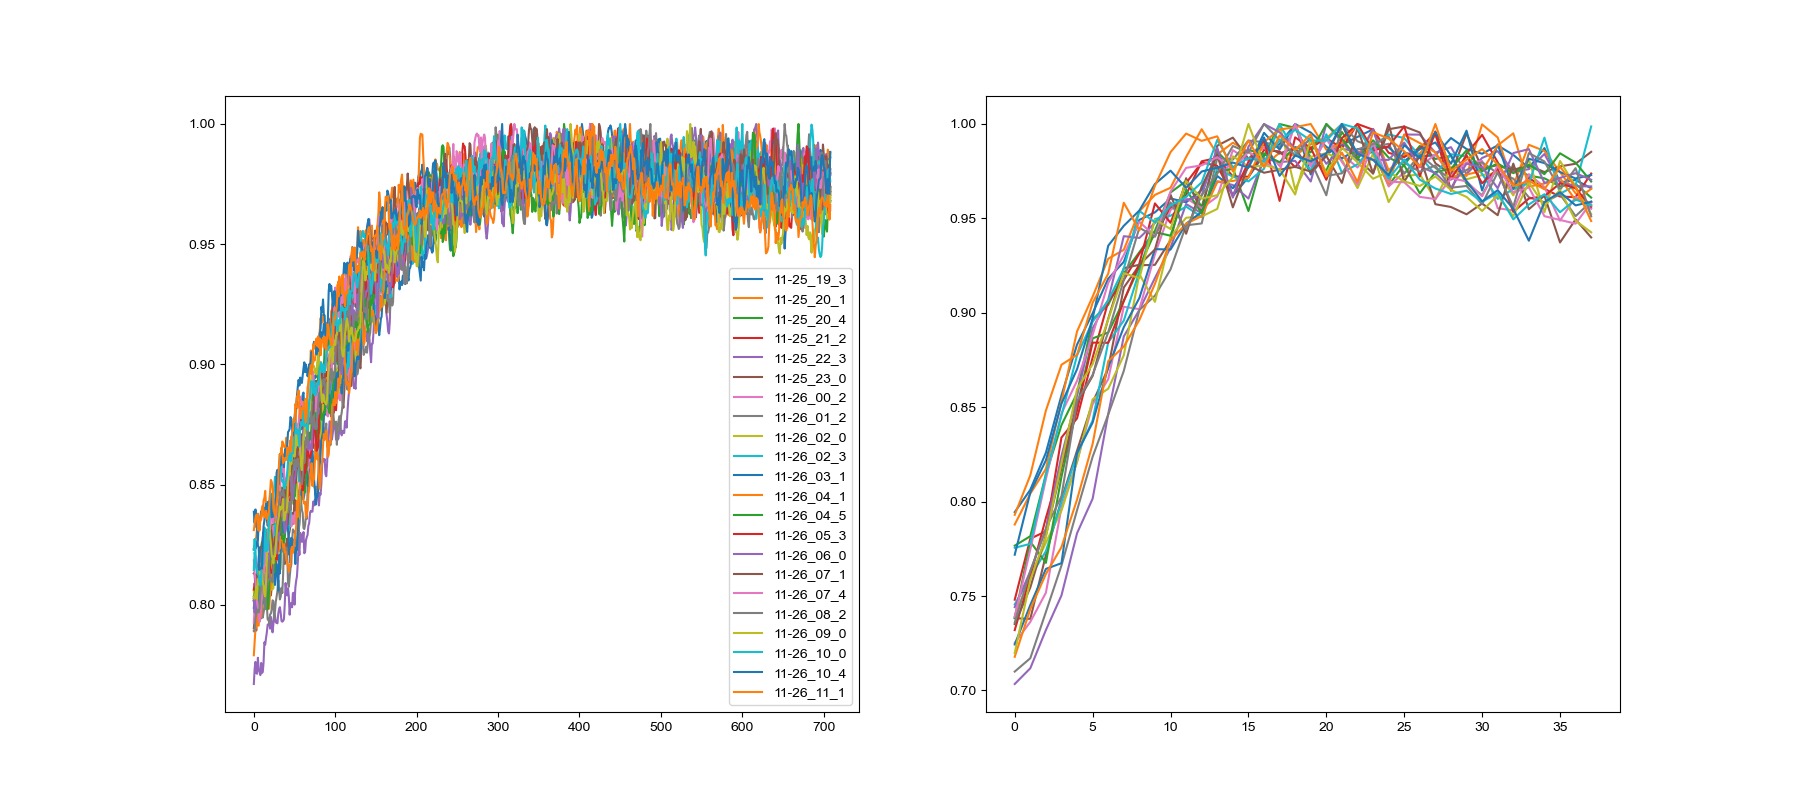

In [26]:
video_frame_intensity = []
time_frame = []
im_tau = []

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

for folder in glob.glob("."):
    for i, f in enumerate(glob.glob(folder + "/*qE_calib*")):
        print("yo0")
        file_path = f + "/video.tiff"
        FO = init_image(file_path)
        print("yo1")
        mask = predict_labels(np.mean(FO.frames[300:600], axis = 0))
        items_dict = label_to_data(mask, FO)
        algae_list = list(items_dict.keys())

        print("yo2")
        video_frame_intensity.append(alienlab.segment.grey_to_rgb(mask))
    
        flat_mask = mask.flatten()

        video = tiff.imread(file_path)
        
        start = 190
        stop = 941
        THRESHOLD = np.max(np.mean(video[start:stop], axis = (1,2)))*0.7
        N_mvg = 5
        print("yo3")
        v_high = np.mean(video, axis = (1,2))
        ind_range = list(range(start,stop))
        trace = v_high[ind_range]
        ind = trace > THRESHOLD
        nind = trace <= THRESHOLD
        pulses = trace[ind]
        zone  = mvgavg(trace[nind], N_mvg)
        file_path = f + "/video_timing.npy"
        v_time_high = np.load(file_path)
        v_time = v_time_high[ind_range]
        time_pulses = v_time[ind]
        time_zone = mvgavg(v_time[nind], N_mvg)
        
        video_zone = video[start:stop][ind]#, FO.x[0]:FO.x[1], FO.y[0]:FO.y[1]][nind]
        del FO
        del video
        axs[0].plot(zone/zone.max(), label = f[-20:-10])
        axs[0].legend()
        axs[1].plot(pulses/pulses.max())
        
        S = video_zone.shape[0]
        
        params_high = Parallel(n_jobs = -1 )(delayed(get_fit)(np.mean(video_zone.reshape(S, -1)[:,flat_mask==i], axis = 1), v_time[ind]) for i in range(len(algae_list)))

        im_tau_high = np.ones(mask.shape)
        for i in range(len(params_high)):
            if i != 0:
                im_tau_high[mask==i]=params_high[i][1]
        im_tau.append(im_tau_high)

        print(i)
        

In [6]:
print("yo0")
file_path = f + "/video.tiff"
FO = init_image(file_path)
plt.figure()
FO.X = 300, 700
FO.y = 300, 700
FO.crop()
plt.imshow(FO.frames[1])

yo0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
plt.figure()
plt.imshow(np.log(im_tau_high))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
video_frame = np.copy(im_tau)
video_frame_rgb = []
for i in range(len(video_frame)):
    video_frame[i]= video_frame[i]//2#(np.log(video_frame[i])*255/np.log(video_frame[i]).max()).astype(int)
    video_frame_rgb.append( alienlab.segment.grey_to_rgb(video_frame[i]))
    #plt.figure()
    
    #plt.imshow(np.log(video_frame[i]))

In [9]:
video_frame_rgb[5].max()

489827.0

In [29]:
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(video_frame_rgb, fps=1)
clip.write_gif('test_pulses.gif', fps=1)

MoviePy - Building file test_pulses.gif with imageio.


In [ ]:
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(video_frame_rgb, fps=1)
clip.write_gif('test6_pulses_st.gif', fps=1)

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
algae_list = list(items_dict.keys())
flat_mask = mask.flatten()

file_path = f + "/video.tiff"

video = tiff.imread(file_path)

THRESHOLD = np.max(np.mean(video[27:180], axis = (1,2)))*0.5
N_mvg = 5


v_high = np.mean(video, axis = (1,2))
ind_range = list(range(27,180))
trace = v_high[ind_range]
ind = trace > THRESHOLD
nind = trace <= THRESHOLD
pulses = trace[ind]
zone  = mvgavg(trace[nind], N_mvg)

video_zone = video[27:180, FO.x[0]:FO.x[1], FO.y[0]:FO.y[1]][nind]

file_path = f + "/video_timing.npy"
v_time_high = np.load(file_path)

v_time = v_time_high[ind_range]
time_pulses = v_time[ind]
time_zone = v_time[nind]

S = video_zone.shape[0]
sh = video_zone.shape

params_high = Parallel(n_jobs = -1 )(delayed(get_fit)(np.mean(video_zone.reshape(S, -1)[:,flat_mask==i], axis = 1), time_zone) for i in range(len(algae_list)))
#params_high = Parallel(n_jobs = -1 )(delayed(get_fit)(video_zone.reshape(S, -1)[:,i], time_zone) for i in range(sh[1]*sh[2]))

im_tau_high = np.zeros(mask.shape)
for i in range(len(params_high)):
    im_tau_high[mask==i]=params_high[i][1]



axs[0].plot(zone)
axs[1].plot(pulses)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'FO' is not defined

In [122]:
plt.figure()
#params_high = np.array(params_high)
#plt.imshow((params_high[:,1].reshape(sh[1], sh[2])))
plt.imshow(np.log(im_tau_high))
plt.imshow(mask)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [115]:
params_high

[array([-7.19431280e-02,  1.06144508e+02,  3.87614770e-01]),
 array([-0.16347738, 24.18039819,  0.32787649]),
 array([ -1.01978779, 378.30457053,   1.09332219]),
 array([-3.49648358e+02,  4.59233794e+05,  3.49919261e+02]),
 array([  -884.84893059, 509668.44355196,    885.07314811]),
 array([ -0.40653587, 116.30285033,   0.60387661]),
 array([-3.26566867e-01,  4.07317807e+02,  5.19156471e-01]),
 array([-9.63891619e+02,  9.79863172e+05,  9.64159319e+02]),
 array([  -564.1511952 , 331941.26072555,    564.3439528 ]),
 array([-0.14858619, 20.42800424,  0.3013149 ]),
 array([-1.68802126e+02,  2.40771793e+05,  1.68885835e+02]),
 array([-0.19540336, 24.75803393,  0.31322969]),
 array([2.22526479e-02, 3.77116799e+01, 2.13697942e-01]),
 array([0.69655119, 0.00752212, 0.30344828]),
 array([  -772.52802988, 427179.88762434,    772.62346672]),
 array([ 1.67810291e+02,  7.46341764e+05, -1.67471285e+02]),
 array([0.69667549, 0.00531521, 0.30344742]),
 array([-0.16473592, 44.90810253,  0.19807462]),
 

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(18, 8))

#voltage = [3, 10, 30, 100, 150, 200, 250, 300, 350, 400, 3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

NN = 20
filter_list = np.array([1]*NN + [0]*NN)#[::-1]
voltage =  [50, 90, 100, 110, 120, 140, 160, 180, 200, 215, 235, 255, 280, 300]
voltage = [0, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300]
np.array(list(np.linspace(0, 450, NN))+list(np.linspace(0, 450, NN)))#[::-1]
voltage = [50, 100, 150, 200, 220, 230, 250, 280, 300, 350, 400, 150]
voltage=[50, 100, 150, 160, 170, 180, 200, 220, 230, 250, 280, 300, 350, 400, 150]
voltage = [10, 20, 30, 40, 50, 100, 150, 160, 170, 180, 200, 220, 230, 250, 280, 300, 350, 400, 150]

W = 100

for i, f in enumerate(glob.glob(file_folder + "/*qE_calib*")):
        print( glob.glob(f))
        file_path = glob.glob(f + "/*_output_plot.csv")[0] # pops up a window to select your file
        data_sequence = pd.read_csv(file_path)

        time_array = np.array(data_sequence["time (s) intensity"])
        fluo  = np.array(data_sequence["voltage (V) fluorescence"])
        fluo = fluo - np.mean(fluo[400:450])
        amplitude = np.array(data_sequence["voltage (V) intensity"])
        
        V = VoltageIntensity()
        intensity = V.get_intensity_voltage('blue', filter_list[i], voltage[i]/100)*1e6
        #fluo = amplitude
        
        x = mvgavg(time_array, W)
        y = mvgavg(fluo, W)#/FM

        mrange = (x>11.4)*(x<11.6)
        FM = np.mean(y[mrange])
        xrange = (x>10)*(x<20)
        axs[0][0].plot(x[xrange], y[xrange]/FM, label = voltage[i])
        axs[0][0].legend()
        qrange = (x>33)*(x<35)
        FQ = np.mean(y[qrange])
        axs[1][0].scatter(intensity, (FM-FQ)/FQ, color = 'k')
        
        axs[0][1].legend()
        
        x = mvgavg(time_array, W)
        xlow = (x>18)*(x<20)
        xhigh = (x>165)*(x<175)
        FP = np.mean(y[xlow])
        FB =  np.mean(y[xhigh])
        xrange = (x>50)*(x<180)*(y<1.3)
        axs[0][1].plot(x[xrange], y[xrange]/FP, label = intensity)
        axs[1][1].scatter(intensity, (FB-FP)/FB)
        axs[0][2].plot(mvgavg(time_array, W), y, label = file_path[-30:-8])
        #axs[1][1].plot(x[xlow], y[xlow])
        axs[0][2].legend()

        axs[1][2].scatter(intensity, FQ, label = file_path[-30:-8])

        up = y>0.001
        down = y<0.001
        axs[2][0].plot(x[up], y[up])
        axs[2][1].plot(x[down], y[down])
        #axs[3].scatter(voltage[i], FQ, color = 'r')
plt.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

['.\\2021-11-07_07_32_qE_calib']
G:/DREAM/from_github/PAMFluo/Experiments\2021-11-03_15_54_bode_diagram


No handles with labels found to put in legend.


['.\\2021-11-07_08_04_qE_calib']
G:/DREAM/from_github/PAMFluo/Experiments\2021-11-03_15_54_bode_diagram
['.\\2021-11-07_08_36_qE_calib']
G:/DREAM/from_github/PAMFluo/Experiments\2021-11-03_15_54_bode_diagram
['.\\2021-11-07_09_07_qE_calib']
G:/DREAM/from_github/PAMFluo/Experiments\2021-11-03_15_54_bode_diagram
['.\\2021-11-07_09_39_qE_calib']
G:/DREAM/from_github/PAMFluo/Experiments\2021-11-03_15_54_bode_diagram
['.\\2021-11-07_10_11_qE_calib']
G:/DREAM/from_github/PAMFluo/Experiments\2021-11-03_15_54_bode_diagram
['.\\2021-11-07_10_43_qE_calib']
G:/DREAM/from_github/PAMFluo/Experiments\2021-11-03_15_54_bode_diagram
['.\\2021-11-07_11_15_qE_calib']


No handles with labels found to put in legend.


G:/DREAM/from_github/PAMFluo/Experiments\2021-11-03_15_54_bode_diagram


In [5]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

#voltage = [3, 10, 30, 100, 150, 200, 250, 300, 350, 400, 3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

NN = 20
filter_list = np.array([1]*NN + [0]*NN)#[::-1]
voltage=[50, 100, 150, 160, 170, 180, 200, 220, 230, 250, 280, 300, 350, 400, 150]
np.array(list(np.linspace(0, 450, NN))+list(np.linspace(0, 450, NN)))#[::-1]

W = 100

for i, f in enumerate(glob.glob(file_folder + "/*qE_calib*")[:-1]):
    #if i > 6 or i<2:
        file_path = f + "/video.tiff"
        video = np.mean(tiff.imread(file_path), axis = (1,2))
        file_path = f + "/video_timing.npy"
        v_time_high = np.load(file_path)
        t0 = v_time_high[0]
        v_time_high = v_time_high -t0
        v_time_high = v_time_high%(3600*24)
        threshold = 7
        xrange = video<threshold
        xrange2 = video>=threshold
        intensity = V.get_intensity_voltage('blue', filter_list[i], voltage[i]/100)*1e6
        intensity2 = V.get_intensity_voltage('blue', filter_list[i], max(0, (voltage[i]-150))/100)*1e6


        axs[0].plot(v_time_high[xrange], video[xrange], label = "%0.0f - %0.0f"%(intensity, intensity2))
        axs[1].plot(v_time_high[xrange2], video[xrange2], label = voltage[i])
        axs[0].legend()


        #axs[3].scatter(voltage[i], FQ, color = 'r')
plt.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
file_path = f + "/video.tiff"
video = tiff.imread(file_path)
plt.figure()
plt.plot(np.mean(video, axis = (1,2)))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
data_sequence = {}
video_sequence = {}
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

file_path = glob.glob(f + "/*_output_plot.csv")[0] # pops up a window to select your file
data_sequence = pd.read_csv(file_path)

time_array = np.array(data_sequence["time (s) intensity"])
fluo  = np.array(data_sequence["voltage (V) fluorescence"])
amplitude = np.array(data_sequence["voltage (V) intensity"])

axs[0].plot(time_array, fluo)
axs[0].set_title("MPPC high, voltage")

start = 0
axs[1].plot(mvgavg(time_array, 100)[start:], (mvgavg(fluo, 100))[start:])
axs[1].set_title("MPPC high, voltage")

plt.savefig(f + "/MPPC.pdf")

file_path = f + "/video.tiff"
video = tiff.imread(file_path)
video_sequence[0]=video
v_high = np.mean(video, axis = (1,2))
file_path = f + "/video_timing.npy"
v_time_high = np.load(file_path)
t0 = v_time_high[0]
v_time_high = v_time_high -t0
v_time_high = v_time_high%(3600*24)


file_path = f + "/video.tiff"
video_file_high = tiff.imread(file_path)


fig = plt.figure()
plt.plot(v_high)
plt.savefig(f + "/video_total.pdf")


zone = []
time_zone = []
video_zone = []

indices_clean = 0, 11, 27, 180, 312, 612, 630, 800, 913, 1213, 1230, 1440, 1513, len(v_high)   ## 0     
#indices_clean = 0, 11, 27, 180, 312, 613, 630, 800, 913, 1214, 1230, 1440, 1514, len(v_high) ## 3
THRESHOLD = 1
N_mvg = 5


for i in range(len(indices_clean)-1):
        ind_range = list(range(indices_clean[i],indices_clean[i+1]))
        trace = v_high[ind_range]
        ind = trace > THRESHOLD
        nind = trace <= THRESHOLD
        zone.append(trace[ind])
        zone.append(mvgavg(trace[nind], N_mvg))
        
        v_time = v_time_high[ind_range]
        time_zone.append(v_time[ind])
        time_zone.append(mvgavg(v_time[nind], N_mvg))
        
        vid = video_file_high[ind_range]
        video_zone.append(vid[ind])
        video_zone.append(mvgavg(vid[nind], N_mvg))

   
coup = 4

fig, axs = plt.subplots(2, coup, figsize=(15, 10))

time_zone[2] = np.append(time_zone[3][0], time_zone[2])
zone[2] = np.append(zone[0][0], zone[2])
video_zone[2] = np.concatenate([video_zone[0], video_zone[2]])

cmap = cm.get_cmap('tab20', 20)

for k in range(len(zone)):
    if len(time_zone[k])>1:
        print(k)
        axs[k%2][(k//2)%coup].plot(zone[k], '.', color = cmap((2*k+1)%20), label = k)
        params, ypred = get_fit(zone[k], time_zone[k], give_y = True)

        axs[k%2][(k//2)%coup].plot(ypred, '-', color = cmap((2*k)%20), label = "%0.2f"%params[1])

        axs[k%2][(k//2)%coup].set_title("zone %d"%k)
        axs[k%2][(k//2)%coup].legend()
plt.savefig(f + "/phase_graph.pdf")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IndexError: index 0 is out of bounds for axis 0 with size 0

In [14]:
cmap = cm.get_cmap('tab20', 27)
p.color_list = [cmap(p) for p in range(27)]
p.yval = zone#[0::2]
p.xval = time_zone#[0::2]
p.figsize = (20, 10)
p.label_list =["%d"%p for p in range(len(zone))]
k = p.plotting(p.xval, p.yval)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
show = True #option to output intermediary images in the segmentation process

# Import video file in HQ and select ROI
file_path = f + "/video.tiff"
direc = os.path.split(file_path)[0]

# Initialize plotting tools
g = alienlab.plot.ShowFigure()
g.figsize = (15,7)
g.save_folder = "images"
g.date = False
p = alienlab.plot.PlotFigure()
p.figsize = (15,7)
p.save_folder = "images"
p.date = False

In [9]:
# read the stacked frame. dim = NxHxW (N images in the video, Heigt, Width)

frames_full = skimage.io.imread(file_path)

#frames_full = np.stack([frames_full[:,:,1]]*10, 0) 
#uncomment this line if you have a single RGB image. The [:,:,1] stands for selection of the green channel

FO = FramesOperator(frames_full)
im = normalize(FO.frames[0], 0, 1)
im = grey_to_rgb(im)*255

# CROP
#y, x = alienlab.io.select_roi(np.uint8(im)) #select area of interest

FO.x = 100, 300
FO.y = 200, 500
#FO.crop() #crop image

start_time = time.time()
FO.compute_stats() #compute various statistical values on the frames and the pixels
FO.normalize(0, 1)
print("--- Computed frames statistics in %04f seconds ---" % (time.time() - start_time))

#FO.global_stats: each array has size N, number of frames and represents the stats of each frame
#FO.frames_stats: each array has size FO.x, FO.y and is an image representing the N frames stats overlayed

if show:
    p.title = 'statistics'
    p.xlabel = 'frame number'
    p.ylabel = 'amplitude'
    p.label_list = ['max', 'min', 'mean', 'std']
    fig = p.plotting(np.asarray(FO.inds), [FO.global_stats['mean'], 
                        FO.global_stats['min'], 
                        FO.global_stats['mean']])
    p.save_name = 'frames_stats'
    p.saving(fig)

''' IMAGE SEGMENTATION '''

# selection of the frames with high dynamics that will be used for the image segmentation process.
# Let M be the highest value taken by a pixel in all the frames of the video. The frame F is kept for processing only if at
# least one pixel in the frame F has a value above 0.8*M. 
FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.8)


--- Computed frames statistics in 19.641273 seconds ---


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:

plt.figure(figsize = (5, 3))
inds_max = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.8) # Select only images with high intensity to increase contrast and lower computation time
inds_med = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.1) # Select only images with high intensity to increase contrast and lower computation time
FO.selected_inds = list(set(inds_med) - set(inds_max))

#FO.selected_inds = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.9) # Select only images with high intensity to increase contrast and lower computation time
#FO.crop() #crop image
imref = FO.frames[FO.selected_inds].sum(axis = 0)

plt.imshow(imref)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
def segment_image(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, interact = True, showit = show):
    
    start_time = time.time()
    inds_max = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.9) # Select only images with high intensity to increase contrast and lower computation time
    inds_med = FO.select_frames(FO.global_stats['max'], FO.global_stats['max'].max()*0.1) # Select only images with high intensity to increase contrast and lower computation time
    FO.selected_inds = np.array(list(set(inds_med) - set(inds_max)))
    
    def make_mask(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, soft_hard_contrast, soft_hard_autolevel):
        #apply contrast filter to all frames
        frames_contrast = FO.apply(skimage.filters.rank.enhance_contrast,  selem = skimage.morphology.disk(contrast))
        #apply autolevel filter to all frames
        frames_autolevel = FO.apply(skimage.filters.rank.autolevel, selem = skimage.morphology.disk(autolevel))
        #sum the contrast images to get a reference grey-level contrast image
        frame_contrast = np.sum(frames_contrast, axis = 0)
        #sum the autolevel images to get a reference grey-level autolevel image
        frame_autolevel = np.sum(frames_autolevel, axis = 0)
        #obtain contrast mask from reference contrast image
        mask_contrast = make_binary(frame_contrast, soft_hard = soft_hard_contrast)
        #otbain autolevel mask from reference autolevel image
        mask_autolevel =  make_binary(frame_autolevel, soft_hard = soft_hard_autolevel)
        #intersection of contrast aud autolevel masks
        mask_intersect = mask_contrast * mask_autolevel
        #clean the masks with a binary opening
        mask_intersect = skimage.morphology.binary_opening(mask_intersect, selem = skimage.morphology.disk(disk_size))
        #mask_intersect = skimage.morphology.binary_erosion(mask_intersect, selem = skimage.morphology.disk(disk_size))

        #reference image of altitude for the watershed
        auto_contrast = normalize(mask_intersect * frame_autolevel)
        print("--- Computed binary mask in %04f seconds ---" % (time.time() - start_time))

        g.cmap = "inferno"
        if showit:
            g.figsize = (20,8)
            g.title_list =  'contrast', 'contrast threshold', 'mask intersect','autolevel', 'autolevel threshold','segmentation image'
            g.col_num = 3
            fig = g.multi([frame_contrast, mask_contrast, mask_intersect, 
                           frame_autolevel, mask_autolevel,  auto_contrast])
            g.save_name = 'Segmentation reference'
            g.saving(fig)
            
        return auto_contrast, mask_intersect
    
    auto_contrast, mask_intersect = make_mask(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, soft_hard_contrast = 1, soft_hard_autolevel = 1)
    ref, mask = make_mask(contrast, autolevel, dist_max, dist_seg, disk_size, max_contrast, soft_hard_contrast = 0.3, soft_hard_autolevel = 0.5)

    start_time = time.time()

    #locate the local maxima
    local_maxi = alienlab.segment.local_maxima(auto_contrast, max_contrast, g,
                                                     ref_distance = dist_max, mask = mask_intersect, show = showit)
    #perform watershed segmentation
    watershed_im_mask = alienlab.segment.watershed(ref*mask_intersect, mask , local_maxi,
                                                         g, ref_distance = dist_seg, show = True)
    segmented = watershed_im_mask
    print("--- Computed segmentation in %04f seconds ---" % (time.time() - start_time))

    #if showit:
    #    alienlab.segment.show_segmentation(FO, segmented, g)
        
    if interact == False:
       return watershed_im_mask, FO
    
mask, FO = segment_image(contrast = 6, autolevel = 5, dist_max = True, dist_seg=True, disk_size = 1, max_contrast = 3, interact = False, showit= True)

g.cmap = "tab20"
g.figsize = (10,5)
fig = g.multi(mask)
plt.savefig(f + "/segmented.pdf")
L, H  = np.shape(mask)

items_dict = label_to_data(mask, FO)

--- Computed binary mask in 81.728597 seconds ---


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

--- Computed binary mask in 167.206381 seconds ---


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

g:\dream\from_github\alienlab\alienlab\segment.py:38: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = skimage.feature.peak_local_max(im, indices = False, min_distance=min_distance)
g:\dream\from_github\alienlab\alienlab\segment.py:41: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  dist_local_maxi = skimage.feature.peak_local_max(distance, indices = False, min_distance=min_distance)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\Alienor\anaconda3\envs\arduino\lib\site-packages\matplotlib\cbook\__init__.py:2293: ResourceWarning: unclosed file <_io.BufferedReader name='G:\\DREAM\\from_github\\PAMFluo\\Experiments\\FOLDER_2021-11-03_300s_2_levels\\2021-11-03_02_46_qE_calib\\2021-11-03_03_17_output_plot.csv'>
  for t, s in zip(target_shape, data_shape)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

--- Computed segmentation in 1.074109 seconds ---


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [00:12<00:00, 29.72it/s]


In [30]:
p.yval = zone[1::2]
p.xval = time_zone[1::2]
p.label_list = ["%d"%i for i in range(len(zone))]
k = p.plotting(p.xval, p.yval)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#x0, x1, y0, y1 = 100, 500, 300, 700
#x0, x1, y0, y1 = 10, 800, 30, 1000
axs[0].imshow(np.mean(video_sequence[0], axis = 0), cmap = "gray")#[2, x0:x1, y0:y1], vmin = 0, vmax = 30)

plt.figure(figsize = (10, 5))
plt.plot(v_time_high, np.mean(video_sequence[0][:, 100:500, 300:700], axis = (1,2)))
plt.xlabel("time (s)")
plt.ylabel("fluorescence intensity")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'fluorescence intensity')

In [32]:

video_high = []

file_path = f + "/video.tiff"
video_file_high = tiff.imread(file_path)


algae_list = list(items_dict.keys())
for P in [5]:#[len(algae_list)]:#[8, 10, 12, 15, 18, 20, 25, 30, 35, 40, 60, 90, 120, 180, 200, 250, 300, 400, 500, 600, 700]:

    #for algae in random.sample(algae_list, P):
    for algae in tqdm(algae_list):
        #if int(algae):# in ['1', '80', '400', '250']:
            i = 0


            x_coords =  items_dict[algae]['x_coords']
            y_coords =  items_dict[algae]['y_coords']
            
            trace = np.mean(video_file_high[:, x_coords, y_coords], axis = (1))
            video_high.append(np.array(trace))

video_high = np.array(video_high)


100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [00:05<00:00, 73.88it/s]


In [33]:


flat_mask = mask.flatten()


L = len(video_zone) + 1
col = 6
fig, axs = plt.subplots(col, 5, figsize=(20,20))

video_list_init = video_zone
time_list = time_zone
video_list = []
for video in video_list_init:
    print(video.shape)
    if video.shape[0]!=0:
        video_list.append(video)

for i, video in enumerate(video_list): 
    video_list[i] = video.reshape(video.shape[0], -1)



for ind in [3, 9, 12]:
    if ind != 0:
        pos = flat_mask == ind
        for i, video in enumerate(video_list):
            if i>1 and len(time_list[i])>2:
                y = np.mean(video[:, pos], axis = 1)    
                x = time_list[i]
                params, ypred = get_fit(y, x-x[0], give_y = True)
                axs[(i+1)%col][(i+1)//col].plot(x, ypred, label = params[1])
                axs[(i+1)%col][(i+1)//col].plot(x, y, '.')
                axs[(i+1)%col][(i+1)//col].legend()
                axs[(i+1)%col][(i+1)//col].set_title("zone %d"%i)

plt.savefig(f + "/example_algae.pdf")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1, 608, 968)
(6, 608, 968)
(2, 608, 968)
(11, 608, 968)
(7, 608, 968)
(142, 608, 968)
(7, 608, 968)
(121, 608, 968)
(15, 608, 968)
(281, 608, 968)
(1, 608, 968)
(13, 608, 968)
(8, 608, 968)
(158, 608, 968)
(6, 608, 968)
(103, 608, 968)
(15, 608, 968)
(281, 608, 968)
(1, 608, 968)
(12, 608, 968)
(10, 608, 968)
(196, 608, 968)
(4, 608, 968)
(65, 608, 968)
(15, 608, 968)
(270, 608, 968)


g:\dream\from_github\alienlab\alienlab\regression_func.py:70: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
g:\dream\from_github\alienlab\alienlab\regression_func.py:70: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
g:\dream\from_github\alienlab\alienlab\regression_func.py:70: RuntimeWarning: overflow encountered in multiply
  return A * np.exp(-xdata/tau) + y0
g:\dream\from_github\alienlab\alienlab\regression_func.py:70: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
g:\dream\from_github\alienlab\alienlab\regression_func.py:70: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
g:\dream\from_github\alienlab\alienlab\regression_func.py:70: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau) + y0
g:\dream\from_github\alienlab\alienlab\regression_func.py:70: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-xdata/tau)

In [56]:
x

array([620.196662])

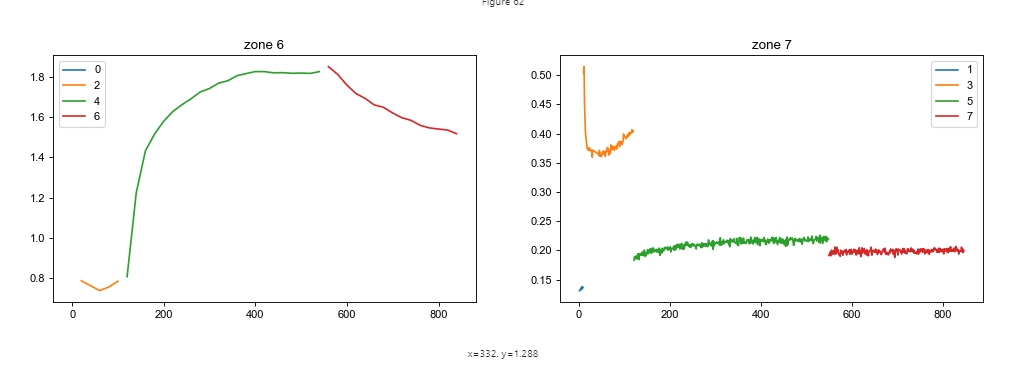

In [34]:
params_tot = []
im_tau = []
for z in range(2,len(zone)):
    if z%2==0:
        fig, axs = plt.subplots(1, 3, figsize = (18, 4))

    S = video_zone[z].shape[0]
    params_high = Parallel(n_jobs = -1 )(delayed(get_fit)(np.mean(video_zone[z].reshape(S, -1)[:,flat_mask==i], axis = 1), time_zone[z]) for i in range(len(algae_list)))
    params_tot.append(np.array(params_high))
    im_tau_high = np.zeros(mask.shape)
    for i in range(len(params_high)):
        im_tau_high[mask==i]=params_high[i][1]

    im_tau.append(im_tau_high)

    params_high = np.array(params_high)
    tau_high = params_high[:,1]
    if z not in [20]:
        axs[0].imshow(np.log(im_tau_high))
        clipped = clip(tau_high, high =80, low = 2)
        if z%2==0:
            axs[1].hist(clipped, color = (1,0,0,0.5))
        else:
            axs[1].hist(clipped, color = (0,0,1,0.5))

            axs[2].scatter(params_tot[z-3][:,1], params_tot[z-2][:,1])
            axs[2].set_xlabel("time(s) pulses")
            axs[2].set_ylabel("time(s) FD")
            axs[2].set_title('zone %d'%z)
            axs[2].set_xlim(clipped.min(), clipped.max())
            axs[2].set_ylim(clipped.min(), clipped.max())
    plt.savefig(f + "/dispersion_zone%d.pdf"%z)
            
np.save(f + "/im_ref.npy", imref)
np.save(f + "/im_tau_high.npy", im_tau_high)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-34-5062cfc32146>:19: RuntimeWarning: invalid value encountered in log
  axs[0].imshow(np.log(im_tau_high))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-34-5062cfc32146>:19: RuntimeWarning: invalid value encountered in log
  axs[0].imshow(np.log(im_tau_high))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-34-5062cfc32146>:19: RuntimeWarning: invalid value encountered in log
  axs[0].imshow(np.log(im_tau_high))
<ipython-input-34-5062cfc32146>:19: RuntimeWarning: invalid value encountered in log
  axs[0].imshow(np.log(im_tau_high))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

ValueError: Residuals are not finite in the initial point.

In [20]:
import importlib

importlib.reload(alienlab.widget)
from alienlab.widget import click_to_graph

file_path = f + "/video.tiff"
video_file_high = tiff.imread(file_path)

video_list =  video_zone
time_list =  time_zone
initial_condition_list = [[],[],[],[],[],[],[],[]]
click_to_graph(mask, np.log(im_tau[3]),video_list,time_list, get_fit, clipit=False)

<ipython-input-20-70720d29f9e6>:12: RuntimeWarning: invalid value encountered in log
  click_to_graph(mask, np.log(im_tau[3]),video_list,time_list, get_fit, clipit=False)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Textarea(value='', description='event:', placeholder='')

# Compare

In [ ]:
mdirectory = askdirectory()


In [ ]:
list_directory = glob.glob(mdirectory + "/*")
plt.figure()
list_val =  [10, 30, 50, 100, 150, 200, 250, 300, 350, 400,10, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450]
for i in range(len(list_directory)):
    file_folder = list_directory[i]
    file_path = glob.glob(file_folder + "/*_qE_decay.csv")[0] # pops up a window to select your file
    data = pd.read_csv(file_path)
    time_array = np.array(data["time (s) q"])
    time_high = time_array[:-10]
    fluo_high  = np.array(data["voltage (V) q"])
    fluo_high = fluo_high[:-10]
    npq_high =  (fluo_high.max()-fluo_high)/fluo_high
    plt.plot(time_high, npq_high, label = list_val[i])
    file_path = glob.glob(file_folder + "/*SP_before_after.csv")[0] # pops up a window to select your file
    data = np.genfromtxt(file_path)
    fm = data[0][0]- data[0][1]
    fmp = data[1][0]-data[1][1]
    #plt.plot(list_val[i], (fm-fmp)/fmp, 'o')
plt.legend()
plt.show()

In [ ]:
data[0]

In [ ]:
list_directory = glob.glob(mdirectory + "/*")

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

minute = 60
lengths_pulse = [300, 150, 50]
periods_pulse = [0.1*minute, 0.5*minute, 1*minute]
move_plate = True

n = 3
means  = {}
stds = {}
means['high'] = np.zeros((n,n))
stds['high'] =  np.zeros((n,n))
means['pulses'] =  np.zeros((n,n))
stds['pulses'] =  np.zeros((n,n))

i = 0
for k, length in enumerate(lengths_pulse): 
    for l, period in enumerate(periods_pulse):
        file_folder = list_directory[i]
        file_path = glob.glob(file_folder + "/*_ojip_curve.csv")[0] # pops up a window to select your file
        data = pd.read_csv(file_path)
        time_array = np.array(data["time (s) o"])
        time_high = time_array[:-10]
        fluo_high  = np.array(data["voltage (V) o"])
        fluo_high = fluo_high[:-10]
        npq_high =  (fluo_high.max()-fluo_high)/fluo_high

        file_path = glob.glob(file_folder + "/measure_pulse.csv")[0] # pops up a window to select your file
        data= pd.read_csv(file_path)
        fluo_pulses  = np.array(data)
        file_path = glob.glob(file_folder + "/time_pulse.csv")[0] # pops up a window to select your file
        data = pd.read_csv(file_path)
        time_pulses  = np.array(data)
        npq_pulses = (fluo_pulses.max()-fluo_pulses)/fluo_pulses

        axs[0][0].plot(time_high, fluo_high)
        axs[0][0].set_title("MPPC high, voltage")

        axs[0][1].plot(time_pulses, fluo_pulses, '.')
        axs[0][1].set_title("MPPC pulses, voltage")


        im_tau_high = np.load(file_folder + "/im_tau_high.npy")
        im_tau_pulses = np.load(file_folder + "/im_tau_pulses.npy")
        axs[1][0].hist(clip(im_tau_high.flatten(), high = 99, low = 1), range = (0, 30), bins = 25, label = "L: %d ms, dt: %d s"%(length, period))
        axs[1][1].hist(clip(im_tau_pulses.flatten(), high = 99, low = 1), range = (0,180), bins = 25, label =  "L: %d ms, dt: %d s"%(length, period))
        
        high = 97
        low = 3
        means['high'][k][l] = np.mean(clip(im_tau_high, high = high, low = low))
        stds['high'][k][l] = np.std(clip(im_tau_high, high = high, low = low))
        means['pulses'][k][l] = np.mean(clip(im_tau_pulses, high = high, low = low))
        stds['pulses'][k][l] = np.std(clip(im_tau_pulses, high = high, low = low))
        
        plt.legend()
        i += 1

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))

axs[0][0].imshow(means["pulses"])
axs[0][0].set_title("mean pulses")

axs[1][0].imshow(means["high"])
axs[1][0].set_title("mean high")

axs[0][1].imshow(stds["pulses"])
axs[0][1].set_title("std pulses")

axs[1][1].imshow(stds["high"])
axs[1][1].set_title("std high")

In [ ]:
list_directory = glob.glob(mdirectory + "/*")


minute = 60
lengths_pulse = [300, 150, 50]
periods_pulse = [0.1*minute, 0.5*minute, 1*minute]

D = len(list_directory)//3

fig, axs = plt.subplots(D, 3, figsize=(10, 2*D))

i = 0
for k, length in enumerate(lengths_pulse): 
    for l, period in enumerate(periods_pulse):
        file_folder = list_directory[i]


        im_tau_high = np.load(file_folder + "/im_tau_high.npy")
        axs[i%D][i//D].imshow(im_tau_high, vmin =0 , vmax = 20)
        axs[i%D][i//D].axis("off")
        i += 1
        
    
D = len(list_directory)//3

fig, axs = plt.subplots(D, 3, figsize=(10, 2*D))

i = 0
for k, length in enumerate(lengths_pulse): 
    for l, period in enumerate(periods_pulse):
        file_folder = list_directory[i]


        im_tau_pulses = np.load(file_folder + "/im_tau_pulses.npy")
        axs[i%D][i//D].imshow(im_tau_pulses, vmin =0 , vmax = 130)
        axs[i%D][i//D].axis("off")
        i += 1

In [ ]:
i//2

